In [1]:
import pickle 
import os
from datetime import datetime,timezone,timedelta
import pickle

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as mtick
from tqdm import tqdm
from scipy import signal
from scipy import stats

import lib_data_filter as dafi
from lib_data_process import libDataProcess as dapr
import lib_import_other_datasource as imoda

In [2]:
C = 299792458 # m/s
FREQUENCY_GPS_L1 = 1575.42 * 10**6
WAVELENTH_GPS_S1 = C/FREQUENCY_GPS_L1

FREQUENCY_GPS_L2 = 1227.6 * 10**6
WAVELENTH_GPS_S2 = C/FREQUENCY_GPS_L2

FREQUENCY_GPS_L5 = 1176.45 * 10**6
WAVELENTH_GPS_S5 = C/FREQUENCY_GPS_L5

# Glonass
FREQUENCY_GLONASS_L1 = 1602 * 10**6
WAVELENTH_GLONASS_S1 = C/FREQUENCY_GLONASS_L1

FREQUENCY_GLONASS_L2 = 1246 * 10**6
WAVELENTH_GLONASS_S2 = C/FREQUENCY_GLONASS_L2

# Galileo
FREQUENCY_GALILEO_L5 = 1176.45 * 10**6
WAVELENTH_GALILEO_S5 = C/FREQUENCY_GALILEO_L5

FREQUENCY_GALILEO_L6 = 1278.7 * 10**6
WAVELENTH_GALILEO_S6 = C/FREQUENCY_GALILEO_L6

FREQUENCY_GALILEO_L7 = 1207.140 * 10**6
WAVELENTH_GALILEO_S7 = C/FREQUENCY_GALILEO_L7

FREQUENCY_GALILEO_L8 = 1191.795 * 10**6
WAVELENTH_GALILEO_S8 = C/FREQUENCY_GALILEO_L8

In [3]:
def generate_frequency(min_height,max_height):
    """
    generate the frequency basis for lsp
    Args:
        min_height (_type_): minimum height
        max_height (_type_): maximum height

    Returns:
        _type_: frequency for lsp in np array
    """
    frequency = np.arange(min_height,max_height,0.001)
    return frequency

In [4]:
def extract_elevation(elevation_array):
    """
    extract the elevation information of the data
    Args:
        elevation_array: the elevation array

    Returns:
        a dict of the elevation info
    """
    temp = {}
    temp['avg'] = np.average(elevation_array)
    temp['min'] = min(elevation_array)
    temp['max'] = max(elevation_array)
    return temp

In [5]:
def extract_azimut(azimut_array):
    """
    extract the azimut information of the data
    Args:
        azimut_array: the azimut array

    Returns:
        a dict of the azimut info
    """
    temp = {}
    temp['avg'] = np.average(azimut_array)
    temp['min'] = min(azimut_array)
    temp['max'] = max(azimut_array)
    return temp

In [6]:
def get_wavelength(snr_type, satellite_code):
    """
    Return the carrier wavelength acoording to
    the satellite system and carrier type
    Args:
        snr_type (_type_): _description_
        satellite_code (_type_): _description_

    Returns:
        _type_: _description_
    """
    glonass_list = {'14':-7,'15':0,'10':-7,'20':2,'19':3,'13':-2,\
                            '12':-1,'01':1,'06':-4,'05':1,'22':-3,'23':3,\
                            '24':2,'16':-1,'04':6,'08':6,'03':5,'07':5,\
                            '02':-4,'18':-3,'21':4,'09':-2,'17':4,'11':0}
    if snr_type == 'snr1':
        if satellite_code[0]=='R':
            frequency_base = FREQUENCY_GLONASS_L1
            pnr = satellite_code[1:]
            channel = glonass_list[pnr]
            frequency_glo = frequency_base + channel * 0.5625 * 10**6
            wavelength = C / frequency_glo
        elif (satellite_code[0]=='G') or (satellite_code[0]=='E'):
            wavelength = WAVELENTH_GPS_S1
        else:
            wavelength = None
    elif snr_type == 'snr2':
        if satellite_code[0]=='R':
            frequency_base = FREQUENCY_GLONASS_L2
            pnr = satellite_code[1:]
            channel = glonass_list[pnr]
            frequency_glo = frequency_base + channel * 0.4375 * 10**6
            wavelength = C / frequency_glo
        elif satellite_code[0]=='G':
            wavelength = WAVELENTH_GPS_S2
        else:
            wavelength = None
    elif snr_type == 'snr5':
        if satellite_code[0]=='E':
            wavelength = WAVELENTH_GALILEO_S5
        elif satellite_code[0]=='G':
            wavelength = WAVELENTH_GPS_S5
        else:
            wavelength = None
    elif snr_type == 'snr7':
        if satellite_code[0]=='E':
            wavelength = WAVELENTH_GALILEO_S7
        else:
            wavelength = None
    elif snr_type == 'snr8':
        if satellite_code[0]=='E':
            wavelength = WAVELENTH_GALILEO_S8
        else:
            wavelength = None
    return wavelength

In [7]:
def calc_lsp_power(elevation_sort,snr_sort,frequency,wavelength):
    """
    this function calculates the lsp power

    Args:
        elevation_sort (np.array): _description_
        snr_sort (np.array): _description_
        frequency (np.array): _description_
        wavelength (float): _description_

    Returns:
        _type_: _description_
    """
    design_matrix = np.concatenate((elevation_sort**2,elevation_sort,\
                np.ones((elevation_sort.size,1))),axis=1)
    para = np.dot(np.linalg.solve(np.dot(design_matrix.T,design_matrix),\
                    design_matrix.T),snr_sort)
    snr_ref = snr_sort - (elevation_sort**2 * para[0,0] + \
                    para[1,0]*elevation_sort + para[2,0])
    x_data = (np.sin(elevation_sort.T*np.pi/180) * 4 * np.pi / wavelength).ravel()
    y_data = snr_ref.ravel()
    try:
        power = signal.lombscargle(x_data,y_data,frequency,normalize=True)
    except AssertionError:
        power = frequency
    return power

In [8]:
def data_prepare(split_data_dict,frequency):
    """
    this function does all the necessary things

    Args:
        split_data_dict (_type_): _description_
        min_height (_type_): _description_
        max_height (_type_): _description_

    Returns:
        _type_: _description_
    """
    split_data_dict_copy=split_data_dict
    for snr_type in split_data_dict_copy:
        for satellite_code in split_data_dict_copy[snr_type]:
            # init the list for power
            split_data_dict_copy[snr_type][satellite_code]['power'] = []
            split_data_dict_copy[snr_type][satellite_code]['elevation'] = []
            split_data_dict_copy[snr_type][satellite_code]['azimut'] = []
            wavelength = get_wavelength(snr_type, satellite_code)
            if wavelength is None:
                continue

            # a loop to calculate the power
            for item in split_data_dict_copy[snr_type][satellite_code]['raw']:
                # sort data by elevation
                dataframe_sort = item.sort_values(by='elevation')

                # get the elevation and azimut information
                ele_dict = extract_elevation(dataframe_sort.loc[:]['elevation'])
                azi_dict = extract_azimut(dataframe_sort.loc[:]['azimut'])
                split_data_dict_copy[snr_type][satellite_code]['elevation'].append(ele_dict)
                split_data_dict_copy[snr_type][satellite_code]['azimut'].append(azi_dict)

                # do the lsp analyse
                elevation_sort = np.array([dataframe_sort['elevation']]).T
                snr_sort = np.array([dataframe_sort[snr_type]]).T
                power = calc_lsp_power(elevation_sort,snr_sort,frequency,wavelength)
                if np.max(power)>0.1:
                    split_data_dict_copy[snr_type][satellite_code]['power'].append(power)
                else:
                    split_data_dict_copy[snr_type][satellite_code]['power'].append(np.array([]))
    return split_data_dict_copy

In [9]:
main_path = os.path.abspath('../data/20230315/4_2/')

starttime = datetime(year=2023,month=3,day=15,hour=7,minute=0,second=0,tzinfo=timezone.utc)

endtime = datetime(year=2023,month=3,day=15,hour=15,minute=0,second=0,tzinfo=timezone.utc)

key_list = ['0315_r2']

In [10]:
azimut_mask = [270,330]
elevation_mask = [10,30]
min_height = 2
max_height = 6
t_range = 30
sample_rate = 1
ts_dict = {}
count_ts = {}
trigger_list = ['snr1','snr2','snr5','snr7','snr8']
dt = 13
frequency = generate_frequency(min_height=min_height,max_height=max_height)

starttime_split = starttime + timedelta(minutes=dt)
endtime_split = endtime + timedelta(minutes=dt)
deltatime = timedelta(minutes=t_range)
split_data_dict = {}
for i,snr_trigger in enumerate(trigger_list):
    data_dict = dafi.clean_data(main_path,azimut_mask=azimut_mask,\
        elevation_mask=elevation_mask,trigger=snr_trigger)
    split_data_dict[snr_trigger] = \
        dafi.split_data(data_dict,starttime_split,endtime_split,\
                        deltatime,sample_rate=sample_rate)
    if i==0:
        split_data_dict_special = split_data_dict



In [11]:
result_dict = data_prepare(split_data_dict_special,frequency=frequency)

In [12]:
signal_ts = {}
power = {}
name ={}
for snr_type in result_dict:
    for satellite_code in result_dict[snr_type]:
        for t,p in zip(result_dict[snr_type][satellite_code]['time'],\
            result_dict[snr_type][satellite_code]['power']):
            if p.any():
                if t in signal_ts:
                    power[t].append(p)
                    name[t].append(f'{satellite_code} L{snr_type[-1]}')
                    signal_ts[t] = np.multiply(p,signal_ts[t])
                    count_ts[t] = count_ts[t]+1
                else:
                    name[t] = [f'{satellite_code} L{snr_type[-1]}']
                    power[t] = [p]
                    signal_ts[t] = p
                    count_ts[t] = 1

In [13]:
t0 = result_dict[snr_type][satellite_code]['time'][0]
mval = max(signal_ts[t0])
mloc = list(signal_ts[t0]).index(mval)
for i,item in enumerate(name[t0]):
    if item[-1] == '2' and item[0]=='G':
        name[t0][i] = f'{item}C'

In [14]:
t0

Timestamp('2023-03-15 11:58:00+0000', tz='UTC')

In [15]:
result_dict

{'snr1': {'G28': {'raw': [                          time   azimut  elevation   snr1
    78   2023-03-15 10:13:01+00:00  306.604     15.068  51.00
    79   2023-03-15 10:13:02+00:00  306.605     15.075  51.10
    80   2023-03-15 10:13:03+00:00  306.606     15.081  51.05
    81   2023-03-15 10:13:04+00:00  306.608     15.088  50.85
    82   2023-03-15 10:13:05+00:00  306.609     15.094  51.05
    ...                        ...      ...        ...    ...
    1873 2023-03-15 10:42:56+00:00  307.751     27.072  50.70
    1874 2023-03-15 10:42:57+00:00  307.750     27.079  50.55
    1875 2023-03-15 10:42:58+00:00  307.750     27.086  50.60
    1876 2023-03-15 10:42:59+00:00  307.750     27.093  50.55
    1877 2023-03-15 10:43:00+00:00  307.750     27.100  50.55
    
    [1800 rows x 4 columns]],
   'time': [Timestamp('2023-03-15 10:28:00+0000', tz='UTC')],
   'power': [array([0.01920973, 0.01942605, 0.01964283, ..., 0.00330255, 0.00329316,
           0.00328431])],
   'elevation': [{'avg': 2

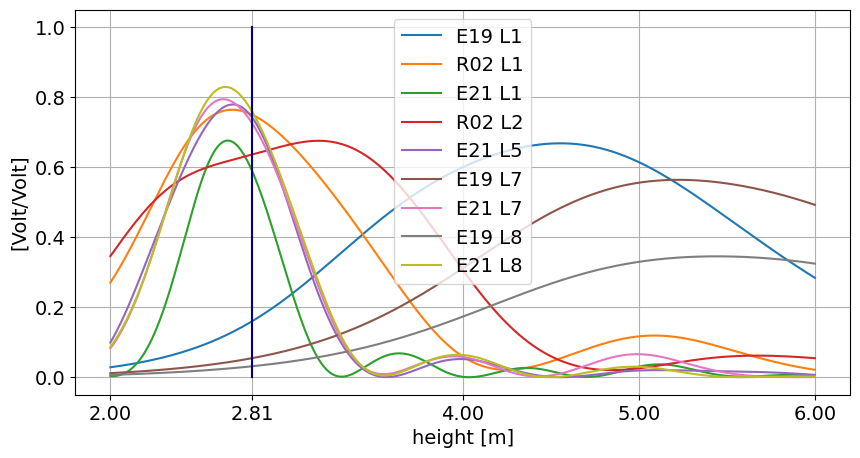

In [16]:
plt.rcParams.update({'font.size': 14})
fig,ax = plt.subplots()

for item in power[t0]:
    ax.plot(frequency,item)
ax.plot([frequency[mloc],frequency[mloc]],[0,1],color='navy')
ax.legend(name[t0])
ax.set_xlabel('height [m]')
ax.set_ylabel('[Volt/Volt]')
ax.grid()
fig.set_size_inches(10,5)
#ax.set_title('Lomb Scargle Periodogram Amplitude from Different Signals')
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
ax.set_xticks([2,frequency[mloc],4,5,6])

In [17]:
azimut_mask = [270,330]
elevation_mask = [10,70]
min_height = 2
max_height = 6
t_range = 30
sample_rate = 1
ts_dict = {}
count_ts = {}
trigger_list = ['snr1','snr2','snr5','snr7','snr8']
dt = 0
frequency = generate_frequency(min_height=min_height,max_height=max_height)

starttime_split = starttime + timedelta(minutes=dt)
endtime_split = endtime + timedelta(minutes=dt)
deltatime = timedelta(minutes=t_range)
split_data_dict = {}
for snr_trigger in trigger_list:
    data_dict = dafi.clean_data(main_path,azimut_mask=azimut_mask,\
        elevation_mask=elevation_mask,trigger=snr_trigger)
    split_data_dict[snr_trigger] = \
        dafi.split_data(data_dict,starttime_split,endtime_split,\
                        deltatime,sample_rate=sample_rate)



In [18]:
result_dict = data_prepare(split_data_dict,frequency=frequency)

In [19]:
signal_ts = {}
power = {}
name ={}
for snr_type in result_dict:
    for satellite_code in result_dict[snr_type]:
        for t,p in zip(result_dict[snr_type][satellite_code]['time'],\
            result_dict[snr_type][satellite_code]['power']):
            if p.any():
                if t in signal_ts:
                    power[t].append(p)
                    name[t].append(f'{satellite_code} L{snr_type[-1]}')
                    signal_ts[t] = np.multiply(p,signal_ts[t])
                    count_ts[t] = count_ts[t]+1
                else:
                    name[t] = [f'{satellite_code} L{snr_type[-1]}']
                    power[t] = [p]
                    signal_ts[t] = p
                    count_ts[t] = 1

In [20]:
t0 = result_dict[snr_type][satellite_code]['time'][0]
mval = max(signal_ts[t0])
mloc = list(signal_ts[t0]).index(mval)
for i,item in enumerate(name[t0]):
    if item[-1] == '2' and item[0]=='G':
        name[t0][i] = f'{item}C'
name[t0]

['G28 L1',
 'G31 L1',
 'E21 L1',
 'G28 L2C',
 'G31 L2C',
 'G28 L5',
 'E21 L5',
 'E21 L7',
 'E21 L8']

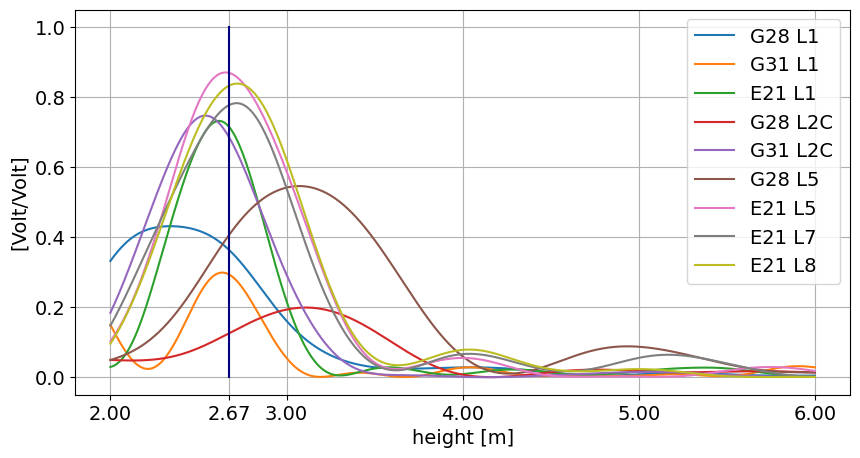

In [21]:
plt.rcParams.update({'font.size': 14})
fig,ax = plt.subplots()

for item in power[t0]:
    ax.plot(frequency,item)
ax.plot([frequency[mloc],frequency[mloc]],[0,1],color='navy')
ax.legend(name[t0])
ax.set_xlabel('height [m]')
ax.set_ylabel('[Volt/Volt]')
ax.grid()
fig.set_size_inches(10,5)
#ax.set_title('Lomb Scargle Periodogram Amplitude from Different Signals')
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
ax.set_xticks([2,frequency[mloc],3,4,5,6])

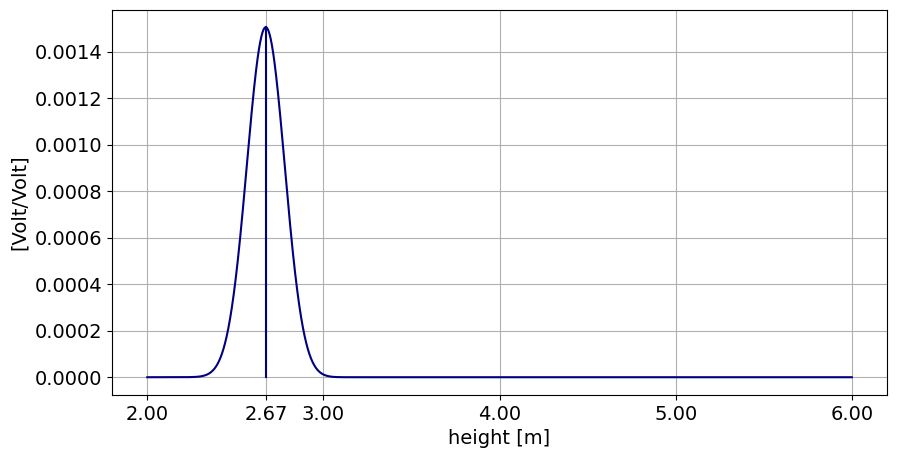

In [22]:
fig,ax = plt.subplots()
t0 = result_dict[snr_type][satellite_code]['time'][0]
ax.plot(frequency,signal_ts[t0],color='navy')
ax.plot([frequency[mloc],frequency[mloc]],[0,mval],color='navy')
ax.set_xlabel('height [m]')
ax.set_ylabel('[Volt/Volt]')
ax.grid()
fig.set_size_inches(10,5)
#ax.set_title('Multiplied Lomb Scargle Periodogram')
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
ax.set_xticks([2,frequency[mloc],3,4,5,6])

In [23]:
name2 = []
pp2 = []
mm = 1
for n,p in zip(name[t0],power[t0]):
    if not (n[0:3] == 'G28'):
        name2.append(n)
        pp2.append(p)
        mm = np.multiply(mm,p)
mval = max(mm)
mloc = list(mm).index(mval)

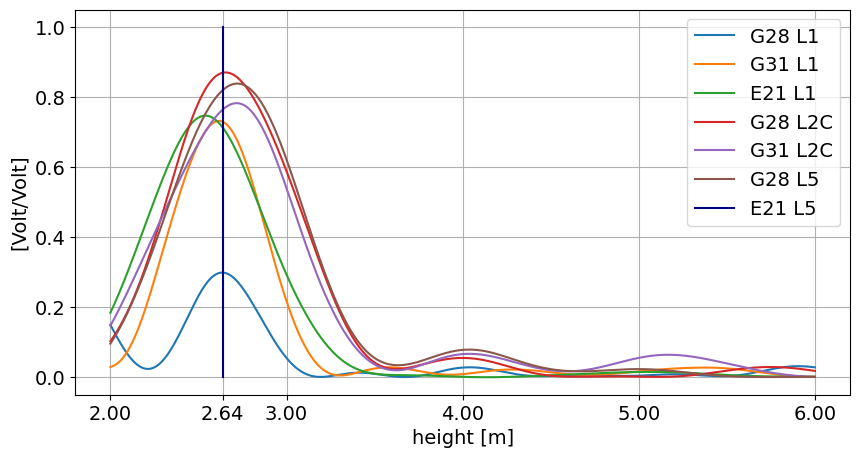

In [24]:
fig,ax = plt.subplots()

for item in pp2:
    ax.plot(frequency,item)
ax.plot([frequency[mloc],frequency[mloc]],[0,1],color='navy')
ax.legend(name[t0])
ax.set_xlabel('height [m]')
ax.set_ylabel('[Volt/Volt]')
ax.grid()
fig.set_size_inches(10,5)
#ax.set_title('Lomb Scargle Periodogram Amplitude from Different Signals')
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
ax.set_xticks([2,frequency[mloc],3,4,5,6])

In [25]:
with open('../data/generated_data/270to330/timeseries_ele5_30_azi270_330_time30_0315_all.pkl', 'rb') as f:
    ts_dict = pickle.load(f)
tbegin = datetime(year=2023,month=3,day=15,hour=8,minute=0,second=0,tzinfo=timezone.utc)
tend = datetime(year=2023,month=3,day=15,hour=12,minute=30,second=0,tzinfo=timezone.utc)
tticklist = [tbegin]
for i in range(1,6):
    tticklist.append(tticklist[i-1]+timedelta(minutes=60))
    print(tticklist[i])

2023-03-15 09:00:00+00:00
2023-03-15 10:00:00+00:00
2023-03-15 11:00:00+00:00
2023-03-15 12:00:00+00:00
2023-03-15 13:00:00+00:00


In [26]:
datekey = '0315-1'
ante_h_1 = imoda.get_antenne_height(datekey)
datekey = '0315-2'
ante_h_2 = imoda.get_antenne_height(datekey)

/Users/yuziqing/Library/CloudStorage/OneDrive-个人/Studium/MA/gnss_ir_analyze/src/lib_import_other_datasource.py:26: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ante_h['1'] = float(index['antenne1'])
/Users/yuziqing/Library/CloudStorage/OneDrive-个人/Studium/MA/gnss_ir_analyze/src/lib_import_other_datasource.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ante_h['r'] = float(index['antenne2r'])
/Users/yuziqing/Library/CloudStorage/OneDrive-个人/Studium/MA/gnss_ir_analyze/src/lib_import_other_datasource.py:26: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ante_h['1'] = float(index['antenne1'])
/Users/yuziqing/Library/CloudStorage/OneDrive-个人/Studium/MA/gnss_ir_analyze/src/lib_import_other_datas

Text(0.5, 0, 'time')

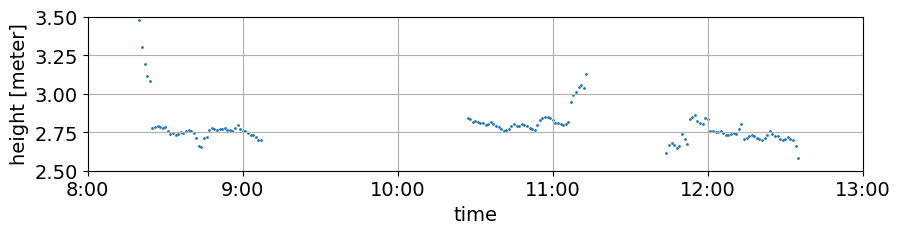

In [28]:
ts_0315_r1 = ts_dict['ts']['0315_r1']
ts_0315_r2 = ts_dict['ts']['0315_r2']
ts_0315_11 = ts_dict['ts']['0315_11']
ts_0315_12 = ts_dict['ts']['0315_12']

time_rotate = list(ts_0315_r1.keys()) + list(ts_0315_r2.keys())
#height_rotate_1 = ante_h_1['1'] - 0.2 - np.asarray(list(ts_0315_r1.values()))
height_rotate_1 = np.asarray(list(ts_0315_r1.values()))
#height_rotate_2 = ante_h_2['1'] - 0.2 - np.asarray(list(ts_0315_r2.values()))
height_rotate_2 = np.asarray(list(ts_0315_r2.values()))
height_rotate = np.concatenate([height_rotate_1,height_rotate_2])

time_stand = list(ts_0315_11.keys()) + list(ts_0315_12.keys())
height_stand_1 = ante_h_1['1'] - np.asarray(list(ts_0315_11.values()))
height_stand_2 = ante_h_2['1'] - np.asarray(list(ts_0315_12.values()))
height_stand = np.concatenate([height_stand_1,height_stand_2])

fig,ax = plt.subplots()

ax.scatter(time_rotate,height_rotate,s=1)
#ax.scatter(time_stand,height_stand,s=1)
#ax.legend(['rotate','normal'])
#ax.set_title('Timeserie of rotated antenna on 15 March with azimuth 270 to 330\n \
#             elevation 5 to 30, and window length 30 minutes')
ax.set_ylim([2.5,3.5])

ax.set_xlim([tbegin,tend])
fig.set_size_inches(10,2)
ax.set_yticks([2.5,2.75,3,3.25,3.5])
ax.set_xticks(tticklist)
ax.set_xticklabels(['8:00','9:00','10:00','11:00','12:00','13:00'])
ax.grid()
ax.set_ylabel('height [meter]')
ax.set_xlabel('time')

In [29]:
print(np.nanmean(height_rotate))
print(np.nanstd(height_rotate))

2.8094099378881645
0.13679106214896847
